# Tutorial: Illustrating use of the `neuronalnetworks` package

## Introuduction

The `neuronalnetworks` package facilitates construction and simulation of dynamical neuronal networks. The core of the package consists of efficient implementations of a number of popular neuronal dynamics models (e.g., leaky integrate-and-fire, FitzHugh-Nagumo, Izhikehich). Other modules can be used to construct sophisticated networks by adding batches of independently parametrizable neurons, specifying geometric structure, generating connectivity matrices, and/or defining inputs. These built-in functionalities can be flexibly mixed and matched or combined with the user's own methods (e.g., arbitrary connectivity specification). All network parameters and components are accessible and modifiable before and during the simulation loop, allowing for full control of rich simulation scenarios.

<div class="alert alert-block alert-info">
This tutorial will walk through the construction and simulation of a network using the `neuronalnetworks` package. We will rapidly build up an elaborate neuronal network and execute a dynamic simulation scenario. While perhaps not biologically meaningful, this simulation will illustrate the range of functionalities offered by this package.
</div>
<div class="alert alert-block alert-info">
Description of steps being taken to create the tutorial network and simulation are highlighted by blue boxes, as opposed to general description of the package (no highlighting).
</div>

# Package Setup

### Installation

[For now] Simply copy the `neuronalnetworks` package directory into your project directory. 

(`pip` installation support forthcoming)

### Importing modules

You can either simply import all package modules (i.e., all models, geometries, connectivities, inputs, plots, etc.):
```python
from neuronalnetworks import *
```

Or import individual modules as needed:
```python
# For example:
# - Importing a neuronal dynamics model:
from neuronalnetworks import LIFNetwork
# - Importing a network input:
from neuronalnetworks.inputs.ConstantInput import ConstantInput
# - Importing a network geometry:
from neuronalnetworks import CylinderSurface
# - Importing connectivity matrix generation functions:
from neuronalnetworks.connectivities.connectivity_generation import *
# - Importing visualization functions:
from neuronalnetworks.visualization.plots import *
from neuronalnetworks.visualization.figures import *
```

---
<div class="alert alert-block alert-info">**For this tutorial, let's import all of the package's modules:**</div>

In [1]:
from os import chdir    
chdir('../') # Navigate to the path containing the package directory from this script location

from neuronalnetworks import *

import numpy as numpy

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


---
# Constructing a neuronal network

We will now illustrate how to use the package to build up a non-trivial neuronal network with our choice of neuronal network geometry, connectivity, inputs, labels, etc. As we step through this process, many of the available options and parameters will be presented (though not necessarily exhaustively). However, you'll notice that in the end we don't need many lines of code to construct our sophisticated network. 

## Neuronal Dynamics Model

This package includes vectorized implementations of several single dynamics models. Networks of abritrary size, connectivity, etc. can be simulated according to these dynamics. 

The supported models are briefly described below:

### Leaky Integrate-and-Fire (LIF) Model:
#### Differential Equations (for single neuron $i$):
$$
\begin{align*}
\frac{dV}{dt} &= R_m \left[ g_{L} (V_{L} - V(t)) + g_{E}(t)(V_E - V(t)) + g_{I}(t)(V_I - V(t)) + g_{gap} \sum_j\left( w_{gap}^{ji} (V^{j}(t) - V^{i}(t))\right) + I_{inp} \right] \\
\frac{dg_{E}}{dt} &= \frac{1}{\tau_{E}} \left( -g_{E}(t) + \sum_j w_{E}^{ji}S_j(t) \right)\\
\frac{dg_{I}}{dt} &= \frac{1}{\tau_{I}} \left( -g_{I}(t) + \sum_j w_{I}^{ji}S_j(t) \right)\\
S_j(t) &= \sum_s \delta(t - t_j^{(s)}) \hspace{2em} \text{(neuron $j$ spike at $t$ indicator function)} \\
&\text{If $V(t) \geq V_{thresh}$ or time since last spike $\leq t_{refrac} \Rightarrow V(t) \leftarrow V_{reset}$}
\end{align*}
$$

#### Parameters/Dimensions & Variable names:

Eqns | Code | Description
--- | --- | ---
$V(t)$ | `V` | Membrane potential
$g_E(t)$ | `g_excit` | Excitatory conductance
$g_I(t)$ | `g_inhib` | Inhibitory conductance
$g_{gap}$ | `g_gap` | Gap junction conductance 
$g_L$ | `g_leak` | Leak conductance
$V_E$ | `V_excit` | Equilibrium excitatory membrane potential 
$V_I$ | `V_inhib` | Equilibrium inhibitory membrane potential 
$V_L$ | `V_leak` | Equilibrium membrane leak potential
$V_{thresh}$ | `V_thresh` | Spike initiation threshold potential 
$V_{reset}$ | `V_reset` | Reset membrane potential
$w_{gap}^{ji}$ | `ConnectionWeights_gap[j,i]` | Weight of gap junction connection between neurons $j$ and $i$ 
$I_{inp}$ | `I_inp` | External input current 
$R_m$ | `R_membrane` | Membrane resitance 
$t_{refrac}$ | `refracPeriod` | Refractory period

#### Instantiating a LIF model network:
```python
network = LIFNetwork()
```

### Izhikevich Model:
#### Differential Equations (for single neuron $i$):
$$
\begin{align*}
\frac{dV}{dt} &= R_m \left[k (V(t) - V_r)(V(t) - V_t) - U(t) + \left(g_{E}(t)(V_E - V(t)) + g_{I}(t)(V_I - V(t)) + g_{gap} \sum_j\left( w_{gap}^{ji} (V^{j}(t) - V^{i}(t))\right) + I_{inp} \right) \right] \\
\frac{dU}{dt} &= a\left[ b(V(t) - V(r)) - U(t) \right] \\
\frac{dg_{E}}{dt} &= \frac{1}{\tau_{E}} \left( -g_{E}(t) + \sum_j w_{E}^{ji}S_j(t) \right)\\
\frac{dg_{I}}{dt} &= \frac{1}{\tau_{I}} \left( -g_{I}(t) + \sum_j w_{I}^{ji}S_j(t) \right)\\
S_j(t) &= \sum_s \delta(t - t_j^{(s)}) \hspace{2em} \text{(neuron $j$ spike at $t$ indicator function)} \\
&\text{If $V(t) \geq V_{peak} \Rightarrow V(t) \leftarrow c$, $U(t) \leftarrow U(t) + d$}
\end{align*}
$$

#### Parameters/Dimensions & Variable names:

Eqns | Code | Description
--- | --- | ---
$V(t)$ | `V` | Membrane potential
$V_r$ | `V_r` | Resting membrane potential
$V_t$ | `V_t` | Instantaneous "threshold" potential
$k$ | `k` | Constant ("$1/R$") 
$U(t)$ | `U` | Recovery variable
$a$ | `a` | Recovery time constant 
$b$ | `b` | Constant ("$1/R$")
$c$ | `V_reset` | Reset membrane potential
$d$ | `d` | Outward-minus-Inward currents activated during spike (affecting post-spike behavior)
$g_E(t)$ | `g_excit` | Excitatory conductance
$g_I(t)$ | `g_inhib` | Inhibitory conductance
$g_{gap}$ | `g_gap` | Gap junction conductance 
$V_E$ | `V_excit` | Equilibrium excitatory membrane potential 
$V_I$ | `V_inhib` | Equilibrium inhibitory membrane potential 
$V_{peak}$ | `V_peak` | Spike cutoff potential
$w_{gap}^{ji}$ | `ConnectionWeights_gap[j,i]` | Weight of gap junction connection between neurons $j$ and $i$ -- 
$I_{inp}$ | `I_inp` | External input current
$R_m$ | `R_membrane` | Membrane resitance

#### Instantiating a Izhikevich model network:
```python
network = IzhikevichNetwork()
```

### FitzHugh-Nagumo (FHN) Model:
#### Differential Equations (for single neuron $i$):
$$
\begin{align*}
\frac{dV}{dt} &= V(t) - \frac{V(t)}{3} - W(t) + g_{gap} \sum_j\left( w_{gap}^{ji} (V^{j}(t) - V^{i}(t))\right) + \left(g_{E}(t)(V_E - V(t)) + g_{I}(t)(V_I - V(t)) + g_{gap} \sum_j\left( w_{gap}^{ji} (V^{j}(t) - V^{i}(t))\right) + I_{inp} \right) \\
\frac{dW}{dt} &= \frac{1}{\tau_W}\left(V(t) + a - b W(t) \right) \\
\frac{dg_{E}}{dt} &= \frac{1}{\tau_{E}} \left( -g_{E}(t) + \sum_j w_{E}^{ji}S_j(t) \right)\\
\frac{dg_{I}}{dt} &= \frac{1}{\tau_{I}} \left( -g_{I}(t) + \sum_j w_{I}^{ji}S_j(t) \right)\\
S_j(t) &= \sum_s \delta(t - t_j^{(s)}) \hspace{2em} \text{(neuron $j$ spike at $t$ indicator function)} 
\end{align*}
$$

#### Parameters/Dimensions & Variable names:

Eqns | Code | Description
--- | --- | ---
$V(t)$ | `V` | Membrane potential
$W(t)$ | `W` | Recovery variable
$\tau_W$ | `tau_W` | Recovery time constant (classically = 12.5)
$a$ | `a` | Constant (classically = 0.7)
$c$ | `b` | Constant (classically = 0.8)
$g_E(t)$ | `g_excit` | Excitatory conductance
$g_I(t)$ | `g_inhib` | Inhibitory conductance
$g_{gap}$ | `g_gap` | Gap junction conductance 
$V_E$ | `V_excit` | Equilibrium excitatory membrane potential 
$V_I$ | `V_inhib` | Equilibrium inhibitory membrane potential 
$w_{gap}^{ji}$ | `ConnectionWeights_gap[j,i]` | Weight of gap junction connection between neurons $j$ and $i$ -- 
$I_{inp}$ | `I_inp` | External input current

#### Instantiating a FHN model network:
```python
network = FHNNetwork()
```

---
<div class="alert alert-block alert-info">**Let's instantiate a network that uses Izhikevich model dynamics:**</div>

In [2]:
network = IzhikevichNetwork()

---
## Adding & Parameterizing Neurons

Neurons can be added to a network in batches, where each group of neurons can be independently parameterized.

Neurons are added to a network by calling the network object's `add_neurons()` function, and passing the relevant neuron parameters as arguments to this function call. Example `add_neurons()` calls for each network model are shown below, illustrating the parameter arguments for each.

#### Adding Neurons to a LIF Network:
```python
network.add_neurons(numNeuronsToAdd=100,
    V_init=-68.0, V_thresh=-50.0, V_reset=-70.0, V_eqLeak=-68.0, V_eqExcit=0.0, V_eqInhib=-70.0,
    g_leak=0.3, g_excit_init=0.0, g_inhib_init=0.0, g_gap=0.5, R_membrane=1.0,
    tau_g_excit=2.0, tau_g_inhib=2.0, refracPeriod=3.0, 
    synapse_type='excitatory', label='') 
```

#### Adding Neurons to a Izhikevich Network:
```python
network.add_neurons(numNeuronsToAdd=100,
    V_init=-65.0, V_r=-60.0, V_t=-40.0, V_peak=30.0, V_reset=-65, V_eqExcit=0.0, V_eqInhib=-70.0, 
    U_init=0.0, a=0.02, b=0.2, d=8, k=0.7, R_membrane=0.01, 
    g_excit_init=0.0, g_inhib_init=0.0, g_gap=0.5, tau_g_excit=2.0, tau_g_inhib=2.0,
    synapse_type='excitatory', label='') 
```

#### Adding Neurons to a FHN Network:
```python
network.add_neurons(numNeuronsToAdd=100,
    V_init=-1.1994, V_peak=1.45, V_eqExcit=2.0, V_eqInhib=-70.0, 
    W_init=-0.6243, a=0.7, b=0.8,
    g_excit_init=0.0, g_inhib_init=0.0, g_gap=0.5, tau_g_excit=2.0, tau_g_inhib=2.0, tau_W=12.5,
    synapse_type='excitatory', label='')
```

Argument Notes (for all network models): 

`synapse_type`: `'excitatory'`|`'inhibitory'`

`label`: optional arbitrary string label applied to all neurons in batch

---
<div class="alert alert-block alert-info">**Let's add a batch of excitatory neurons and a batch of inhibitory neurons to our network:**</div>

In [3]:
N_excit = 100    # number of excitatory neurons
N_inhib = 20    # number of inhibitory neurons

network.add_neurons(numNeuronsToAdd=N_excit,
    V_init=-65.0, V_r=-60.0, V_t=-40.0, V_peak=30.0, V_reset=-65, V_eqExcit=0.0, V_eqInhib=-70.0, 
    U_init=0.0, a=0.02, b=0.2, d=8, k=0.7, R_membrane=0.01, 
    g_excit_init=0.0, g_inhib_init=0.0, g_gap=0.5, tau_g_excit=2.0, tau_g_inhib=2.0,
    synapse_type='excitatory') 

network.add_neurons(numNeuronsToAdd=N_inhib,
    V_init=-65.0, V_r=-60.0, V_t=-40.0, V_peak=30.0, V_reset=-65, V_eqExcit=0.0, V_eqInhib=-70.0, 
    U_init=0.0, a=0.02, b=0.2, d=8, k=0.7, R_membrane=0.01, 
    g_excit_init=0.0, g_inhib_init=0.0, g_gap=0.5, tau_g_excit=2.0, tau_g_inhib=2.0,
    synapse_type='inhibitory') 

<div class="alert alert-block alert-info">**We can get lists of the neuron IDs for the excitatory and inhibitory neurons. This is convenient for referencing and handling excitatory and inhibitory neurons seperately later.**</div>

In [4]:
neuronIDs_excit = numpy.where(network.neuronSynapseTypes == 'excitatory')[0]
neuronIDs_inhib = numpy.where(network.neuronSynapseTypes == 'inhibitory')[0]

In [5]:
neuronIDs_excit

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [6]:
neuronIDs_inhib

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119])

---
## Network Geometries

A physical geometry can be specified on/in which the neurons of the network are located. Network geometry implementations enable automated positioning of neurons and calculation of distances between neurons within the given geometry. This positional and distance information may be used in determining connectivities or other simulation phenomena.

Several geometry implementations are available. "Surface" geometries (e.g., PlaneSurface, CylinderSurface, TorusSurface, SpheroidSurface) place neurons on the surface of the corresponding geometric object, and distances are calculated along this 2D surface. "Volume" geometries (e.g., CubeVolume, CylinderVolume, TorusVolume, AnnulusVolume, EllipsoidVolume) place neurons in the 3D space within the bounds of the geometric object, and distances are calculated directly through the 3D space.

### Instantiating Geometries

#### Parameters for Constructing Geometries
The parameters defining the geometry are given below along with the constructor call used to instantiate each (some geometries have multiple parameterizations/constructors):

Geometry class | Parameters | Constructors
---|---|---
PlaneSurface|$x,y$: width and height of plane|`PlaneSurface(x=<float>, y=<float>, origin=<2D tuple>)`
CylinderSurface|$r,h$: radius and height of cylinder|`CylinderSurface(r=<float>, h=<float>, origin=<2D tuple>)`
|$w,h$: width and height of cylinder's unwrapped surface plane|`CylinderSurface(w=<float>, h=<float>, origin=<2D tuple>)`
TorusSurface|$r_{major},r_{minor}$: radius of loop, radius of disk|`TorusSurface(r_major=<float>, r_minor=<float>, origin=<2D tuple>)`
|$w,h$: width and height of torus's unwrapped surface plane|`TorusSurface(w=<float>, h=<float>, origin=<2D tuple>)`
SpheroidSurface|$r_{xy}, r_z$: radius of spheroid in x-y plane, radius of spheroid in z axis | `SpheroidSurface(r_xy=<float>, r_z=<float>, origin=<2D tuple>)`
CubeVolume | TODO | `TODO`
CylinderVolume | TODO | `TODO`
TorusVolume | TODO | `TODO`
AnnulusVolume | TODO | `TODO`
EllipsoidVolume | TODO | `TODO`

Each network object has a `geometry` attribute which can be set to an instance of one of the above geometry objects.

```python
network.geometry = PlaneSurface(x=10, y=10)
```

#### Adding neurons to a geometry:
Neurons must be added to the network's geometry object before they can be positioned. 

If the network object's geometry attribute is set to a geometry instance before neurons are added to the network, then neurons are automatically added to the associated geometry when `<NeuronNetwork>.add_neurons(...)` is called.
```python
network = IzhikevichNetwork()
network.geometry = PlaneSurface(x=1, y=2)
network.add_neurons(numNeuronsToAdd=100, ...) # network automatically adds new neurons to geometry, since its geometry is already instantiated
```
However, if the network object's geometry attribute is not set to a geometry instance when neurons are added to the network, they need to be explicitly added to the geometry once the geometry instance is instantiated and set:
```python
network = IzhikevichNetwork()
network.add_neurons(numNeuronsToAdd=100, ...)
network.geometry = PlaneSurface(x=1, y=2)
network.geometry.add_neurons(numNeuronsToAdd=100) # need to add neurons to geometry now that it is instantiated
```

---
<div class="alert alert-block alert-info">**Let's have our network reside on the surface of a cylinder:**</div>

In [7]:
network.geometry = CylinderSurface(r=3, h=10)

<div class="alert alert-block alert-info">Now, we add neurons to the geometry instance, since the network's geometry was not instantiated until after we added our batches of neurons:</div>

In [8]:
network.geometry.add_neurons(numNeuronsToAdd=N_excit+N_inhib)

---
### Positioning Neurons
Neurons can be positioned on/in a given geometry evenly (as in a grid), randomly, or according to a list of given positions by calling the `position_neurons()` method of the geometry object with the appropriate arguments.

#### Arguments to `position_neurons()` method:

`<NetworkGeometry>.position_neurons(positioning='random', coords=None, bounds={}, neuronIDs=None)`

Argument|Supported values
---|---
`positioning`|`random`: generate positions randomly within the geometry (and given bounds if applicable)
|`even`: generate positions that are evenly spaced in a grid within the geometry (and given bounds if applicable)
|`given`: assign positions that are given in a list passed to the `coords` argument
`coords`|list of coordinate tuples to be used as given positions when `positioning=given`
`bounds`|dictionary of tuple ranges bounding positions that can be generated (ex: `{theta: [0,numpy.pi/2], h:[0,2]}`) (default = no bounds, (i.e. full geometry)
`neuronIDs`|list of neuron IDs for which to generate positions; if None, generate positions for alkl `N` neurons in network (default = None (i.e. all neurons))

#### Cooridinate Systems
Each geometry class stores the positions of neurons in at least two coordinate systems:
- `parametricCoords`: Neuron positions stored as parametric coordinates, which relate to the parameters that define the dimensions of the given geometry. For example, a CylinderSurface can be defined by a radius and height, and neuron positions on this surface can accordingly be referenced by an angle $\theta$ about the radius and height $h$ from the base - these are the parametric coordinates $(\theta, h)$ for neuron positions for the CylinderSurface geometry. 

Geometry class | Parametric Coords | Description of Parametric Coords
---|---|---
PlaneSurface|$(x,y)$|(x coord, y coord) in x-y plane that is the geometry
CylinderSurface|$\theta,h$|(angle of ray from cylinder center to point on surface, height of point from base)
TorusSurface|$\theta,\phi$|(angle of local ring containing point, angle of ray from center of local ring to point)
SpheroidSurface|$\theta,\phi$|(longitudinal angle of point, latitudinal angle of point)
CubeVolume | TODO | `TODO`
CylinderVolume | TODO | `TODO`
TorusVolume | TODO | `TODO`
AnnulusVolume | TODO | `TODO`
EllipsoidVolume | TODO | `TODO`

- `cartesianCoords`: Neuron positions stored in 3D cartesian coordinates, $(x,y,z)$. 

- `surfacePlaneCoords`: Surface geometries store neuron positions in a third "surface plane" coordinate system: the 2D $(x,y)$ coordinates of points on the rectangular plane that represents the geometry's surface unwrapped and laid down as a 2D plane (not applicable to SpheroidSurface).

Each geometry class has functions for converting neuron positions between coordinate systems, though this is done automatically when neurons are positioned, and current neuron positions in all coordinate systems can be accessed directly at any time (e.g., `network.geometry.parametricCoords`, `network.geometry.cartesianCoords`, `network.geometry.surfacePlaneCoords`).

---
<div class="alert alert-block alert-info">**We will position our network's excitatory neurons evenly over the full cylinder surface, and position the inhibitory neurons randomly in a limited band around the midline of the cylinder:**</div>

In [9]:
network.geometry.position_neurons(positioning='even', neuronIDs=neuronIDs_excit)
network.geometry.position_neurons(positioning='random', bounds={'h':[4,6]}, neuronIDs=neuronIDs_inhib)

Let's take a look at our network's geometry and neuron positions. (A number of network plots are provided, we use one here. Excitatory neurons are colored blue, inhibitory red):

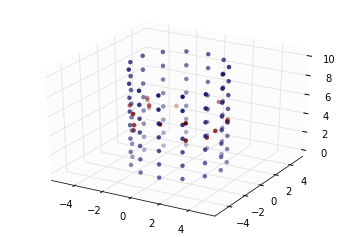

In [10]:
axsyn3d = pyplot.subplot(projection='3d')
synapse_network_diagram_3d(axsyn3d, network)
pyplot.show()

---

### Distances Between Neurons

#### Calculating distances

Distances between neurons are automatically calculated every time neurons are positioned (by a call to `<NetworkGeometry>.position_neurons(...)`)

Distances can also be manually calculated at any time with a call to `<NetworkGeometry>.calculate_distances()`

Each geometry calculates distances in a manner appropriate to the geometry. A description of each distance calculation is given below:

Geometry class | Distance calculation
---|---
PlaneSurface|Euclidean distance in 2D plane
CylinderSurface|Euclidean distance in 2D unwrapped surface plane, torroidal wrapping in circumferal axis
TorusSurface|Euclidean distance in 2D unwrapped surface plane, torroidal wrapping in both circumferal axes
SpheroidSurface|Geodesic ('great circle') distance over the spheroid surface
CubeVolume | Euclidean distance in 3D space
CylinderVolume | Euclidean distance in 3D space
TorusVolume | Euclidean distance in 3D unwrapped circular prism, torroidal wrapping
AnnulusVolume | Euclidean distance in 3D unwrapped rectangular prism, torroidal wrapping
EllipsoidVolume | Euclidean distance in 3D space


#### Accessing calculated distances
The matrix of calculated pairwise distances between positioned neurons is accessible as the `<NetworkGeometry>.distances` (or `<NeuronNetwork>.<NetworkGeometry>.distances>`) attribute.

---
<div class="alert alert-block alert-info">Distances between neurons in our network were already calculated when the neurons were positioned:</div>

In [11]:
network.geometry.distances

array([[ 0.        ,  1.44996584,  2.89993168, ...,  6.45883002,
         4.30862081,  7.08343643],
       [ 1.44996584,  0.        ,  1.44996584, ...,  7.18921329,
         4.9551709 ,  8.03871803],
       [ 2.89993168,  1.44996584,  0.        , ...,  8.11528756,
         5.89474561,  9.12533317],
       ..., 
       [ 6.45883002,  7.18921329,  8.11528756, ...,  0.        ,
         2.23701478,  1.55690681],
       [ 4.30862081,  4.9551709 ,  5.89474561, ...,  2.23701478,
         0.        ,  3.31048584],
       [ 7.08343643,  8.03871803,  9.12533317, ...,  1.55690681,
         3.31048584,  0.        ]])

---
## Network Connectivity

### Setting network connectivity

Each network stores separate connectivity weighth matrices for excitatory synaptic connections, inhibitory synaptic connections, and gap junction connections, namely:

- `<NeuronNetwork>.connectionWeights_synExcit`
- `<NeuronNetwork>.connectionWeights_synInhib`
- `<NeuronNetwork>.connectionWeights_gap`

**These matrices can be set/modified directly, as in:**
```python
network = LIFNetwork()
#...
network.connectionWeights_synExcit = numpy.random.rand(network.N, network.N)
```

**Or connectivity matrices can be set using a call to one of the network's connectivity setter functions:**
- `<NeuronNetwork>.set_synaptic_connectivity(connectivity, updateNeurons=None, synapseType=<'excitatory'|'inhibitory'>)`
- `<NeuronNetwork>.set_gapjunction_connectivity(connectivity, updateNeurons=None)`

These functions provide checks on connectivity matrix dimensionality and format. They also allow for setting the connectivity vectors for a subset of neurons. For example, the following code sets the connectivity of 5 specific neurons to random weights, while leaving the rest of the weights alone:
```python
network = LIFNetwork()
#...
network.set_gapjunction_connectivity(connectivity=numpy.random.rand(5, network.N), updateNeurons=[2,17,34,87,96])
```

### Generating network connectivity matrices/vectors

Functions for generating connectivity matrices or vectors according to a number of heuristics are provided in the `neuronalnetworks.connectivities.connectivity_generation` module:

- `generate_connectivity_vector(N, adjacencyScheme, initWeightScheme, args={}, sparsity=0.0, selfLoops=False, neuronID=None)`   
 - Generates a 1xN vector of connectivity weights according to the given adjacencyScheme, initWeightScheme, and other arguments:
   - `N`: number of neurons [in network] for which a connectivity weight should be generated.
   - `adjacencyScheme`: explained below
   - `initWeightScheme`: explained below
   - `args`: dictionary of arguments relevant to the given `adjacencyScheme` and `initWeightScheme`, explained below
   - `sparsity`: multiplier applied to generated weights vector to increase sparsity if argument is non-zero
   - `selfLoops`: If False, ensure vector has 0 weight at index corresponding to this same neuron.
   - `neuronID`: The neuron ID for which connectivity vector is being generated, necessary to know which vector element represents a self-connection
 
 
- `generate_connectivity_vectors(neuronIDs, N, adjacencyScheme, initWeightScheme, args={}, sparsity=0.0, selfLoops=False)`
 - Generates a set of 1xN vectors of connectivity weights according to the given adjacencyScheme, initWeightScheme, and other arguments by repeated calls to `generate_connectivity_vector`:
   - `neuronIDs`: List of neuronIDs for which a connectivity weight vector should be generated.
   - `N`: number of neurons [in network] for which a connectivity weight should be generated.
   - `adjacencyScheme`: explained below
   - `initWeightScheme`: explained below
   - `args`: dictionary of arguments relevant to the given `adjacencyScheme` and `initWeightScheme`, explained below
   - `sparsity`: multiplier applied to generated weights vector to increase sparsity if argument is non-zero
   - `selfLoops`: If False, ensure vector has 0 weight at index corresponding to this same neuron.
   
   
- `generate_connectivity_matrix(N, adjacencyScheme, initWeightScheme, args={}, sparsity=0.0, selfLoops=False)`
 - Generates a NxN connectivity weight matrix according to the given adjacencyScheme, initWeightScheme, and other arguments by repeated calls to `generate_connectivity_vector`:
   - `N`: number of neurons [in network] for which a connectivity weight should be generated.
   - `adjacencyScheme`: explained below
   - `initWeightScheme`: explained below
   - `args`: dictionary of arguments relevant to the given `adjacencyScheme` and `initWeightScheme`, explained below
   - `sparsity`: multiplier applied to generated weights vector to increase sparsity if argument is non-zero
   - `selfLoops`: If False, ensure vector has 0 weight at index corresponding to this same neuron.
   
#### Adjacency Schemes
Several heuristics for determining which neurons shall be adjacent (i.e., have non-zero connectivity weight) are implemented. To use an adjacency scheme, pass the corresponding scheme string name (see table below) as the `adjacencyScheme` argument to one of the above generator functions, and pass a dictionary that includes the appropriate scheme arguments as the `args` argument (see table below).

adjacencyScheme | Description | Scheme arguments
---|---|---
`'nonspatial_probability'` | Adjacency between $i,j$ with fixed probability $p$ | `{'prob':<float>}`
`'nonspatial_degree'` | Each neuron has $degree$ outgoing connections to randomly chosen targets | `{'degree':<int>}`
`'nearest_neighbors'` | Each neuron has $k$ outgoing connections to its $k$ nearest neighbors | `{'k':<int>, 'distances':<2D distances matrix>}`
`'distance_threshold'` | Each neuron has outgoing connections to all neurons within distance $d_{thresh}$ | `{'d_thresh':<int>, 'distances':<2D distances matrix>}`
`'distance_probability'` | Adjacency between $i,j$ with probability as function of distance between $i$ and $j$ | (see below)
|probability decreases linearly with distance $\\p^{ij} = m D(i,j) + b$:|`{'adj_prob_dist_fn':'linear', 'm_a':<float>, 'b_a':<float> 'distances':<2D distances matrix>}`
|probability decays exponentially with distance $\\p^{ij} = p_0 e^{\sigma D(i,j)}$:|`{'adj_prob_dist_fn':'exponential', 'p0_a':<float>, 'sigma_a':<float> 'distances':<2D distances matrix>}`


#### Initial Weight Schemes
Several heuristics for initializing the connection weights of pre-determined adjacent neurons are implemented. To use an initial weight scheme, pass the corresponding scheme string name (see table below) as the `initWeightScheme` argument to one of the above generator functions, and pass a dictionary that includes the appropriate scheme arguments as the `args` argument (see table below).

initWeightScheme | Description | Scheme arguments
---|---|---
`'constant'` | Weights of all adjacencies are equal, $c_w$ | `{'c_w':<float>}`
`'uniform'` | Weights of adjacencies are randomly sampled from uniform distribution over [low, high] | `{'low':<float>, 'high':<float>}`
`'normal'` | Weights of adjacencies are randomly sampled from normal distribution $N(mean,std)$ | `{'mean':<float>, 'std':<float>}`
`'distance'` | Weight of adjacency $i,j$ is a function of distance between $i$ and $j$ | (see below)
|weight decreases linearly with distance $\\w^{ij} = m D(i,j) + b$:|`{'init_weight_dist_function':'linear', 'm_w':<float>, 'b_w':<float> 'distances':<2D distances matrix>}`
|weight decays exponentially with distance $\\w^{ij} = p_0 e^{\sigma D(i,j)}$:|`{'init_weight_dist_function':'exponential', 'p0_w':<float>, 'sigma_w':<float> 'distances':<2D distances matrix>}`

**Note:** It should be reiterated that the user is not limited to these connectivity generation functions. Ultimately, the network object's connectivity matrices simply store standard numpy 2d arrays, and any method for generating arbitrary matrices/vectors in the form of numpy arrays can be used to set and modify connectivities as desired.


---
<div class="alert alert-block alert-info">**Let's configure our synaptic connectivities such that probability of neuron adjacency decays with their distance. Excitatory synaptic connections will have weights that decrease linearly in distance, while inhibitory synaptic connections will have weights that decrease exponentially in distance:**</div>

In [12]:
W_synE = generate_connectivity_vectors(neuronIDs=neuronIDs_excit, N=network.N, adjacencyScheme='distance_probability', initWeightScheme='uniform',
            args={'adj_prob_dist_fn':'exponential', 'p0_a':1.0, 'sigma_a':1.2, 
                  'low':20.0, 'high':40.0,
                  'distances':network.geometry.distances} )

W_synI = generate_connectivity_vectors(neuronIDs=neuronIDs_inhib, N=network.N, adjacencyScheme='distance_probability', initWeightScheme='distance',
            args={'adj_prob_dist_fn':'exponential', 'p0_a':1.0, 'sigma_a':0.95, 
                  'init_weight_dist_fn':'exponential', 'p0_w':40, 'sigma_w':5.0,
                  'distances':network.geometry.distances} )

network.set_synaptic_connectivity(connectivity=W_synE, synapseType='e', updateNeurons=neuronIDs_excit)
network.set_synaptic_connectivity(connectivity=W_synI, synapseType='i', updateNeurons=neuronIDs_inhib)

Let's take a look at our network's synaptic connectivity:

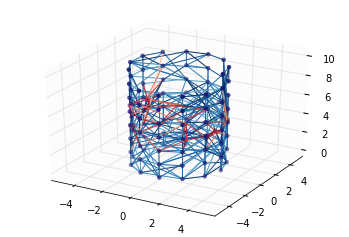

In [13]:
axsyn3d = pyplot.subplot(projection='3d')
synapse_network_diagram_3d(axsyn3d, network)
pyplot.show()

<div class="alert alert-block alert-info">**We can also configure our network's gap junction connectivity. For gap junctions, let's use a nearest-neighbors adjacency scheme. But let's add an additional element  to this connectivity: Let's make the gap junction connectivity increasingly sparse as you move up the length of the cylinder:**</div>

In [14]:
W_synG = numpy.zeros(shape=(network.N, network.N))    # starting with empty container for connectivity matrix

for nID in network.get_neuron_ids():
    # Generate and set connectivity vectors one neuron at a time, 
    # using their percentile height on the cylinder as a parameter 
    # for the additional sparsity applied to the generated vector.
    heightPercentile = network.geometry.cartesianCoords[nID][2]/network.geometry.h
    W_synG[nID] = generate_connectivity_vector(N=network.N, neuronID=nID,
                                               adjacencyScheme='nearest_neighbors', initWeightScheme='constant', 
                                               args={'k':4,'c_w':1.0, 'distances':network.geometry.distances[int(nID)]}, 
                                               sparsity=heightPercentile )

network.set_gapjunction_connectivity(connectivity=W_synG)

Now let's take a look at our network's gap junction connectivity:

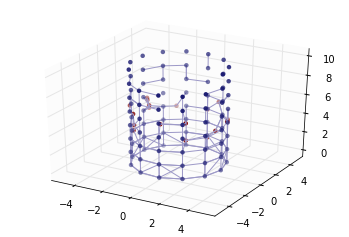

In [15]:
axgap3d = pyplot.subplot(projection='3d')
gapjunction_network_diagram_3d(axgap3d, network)
pyplot.show()

---
## Network Inputs

Initialize
sim_state_valid